In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Гипотезы:
## 1) дерево решений лучше себя покажет чем линейная регрессия по метрикам  и точности(RMSE, RAE, R2 score), так как есть много нелинейных зависимостей
## 2) Сильнее всего на цену будет влиять наличие происшествий, пробег, год выпуска
## 3) При глубине дерева > 10-15 будет переобучение из-за большого числа выбора категориальных данных
## 4) L1, L2 - регуляризации улучшат результат из-за отбора/сжатия признаков


In [2]:
df = pd.read_csv('used_cars.csv')
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


### Посмотрим на количество NaN в данных

In [4]:
df.isna().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

### Посмотрим количество уникальных значений в каждом столбце

In [5]:
df.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

### Вначале уберем все строки где встречаются nan, чтобы обрабатывать данные без пропусков

In [6]:
df.dropna(inplace=True)

### У нас есть пробег и цена, но пока что они не являются числами. Сконвертируем их:

In [7]:
df['milage'] = df['milage'].str.split(' ', n=1).str[0].str.replace(',','').astype(int)
df['price'] = df['price'].str.split('$').str[1].str.replace(',', '').astype(int)

In [8]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500
6,Audi,S3 2.0T Premium Plus,2017,84000,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,31000
7,BMW,740 iL,2001,242000,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,7300


In [9]:
df['clean_title'].unique()

array(['Yes'], dtype=object)

### Можем убрать столбец clean_title так как он содержит одинаковые значения и будет бесполезен в модели, так как будет выбрано "Yes" независимо от чего

In [10]:
df.drop('clean_title', axis=1, inplace=True)

In [11]:
df['accident'].unique()

array(['At least 1 accident or damage reported', 'None reported'],
      dtype=object)

Закодируем как число 0/1:

In [12]:
df.loc[(df['accident'] == 'At least 1 accident or damage reported'), 'accident'] = 1
df.loc[(df['accident'] == 'None reported'), 'accident'] = 0
df['accident'] = df['accident'].astype(int)

In [13]:
df.describe()

,model_year,milage,accident,price
count,3269.000000,3269.000000,3269.000000,3.269000e+03
mean,2014.601407,72126.951973,0.286632,4.124113e+04
std,6.152181,53387.413623,0.452257,8.304604e+04
min,1974.000000,100.000000,0.000000,2.000000e+03
25%,2011.000000,30450.000000,0.000000,1.550000e+04
50%,2016.000000,62930.000000,0.000000,2.800000e+04
75%,2019.000000,102750.000000,1.000000,4.650000e+04
max,2024.000000,405000.000000,1.000000,2.954083e+06


### По описанию видно, что дисперсия для цены и пробега слишком большие относительно средних, вероятно есть выбросы

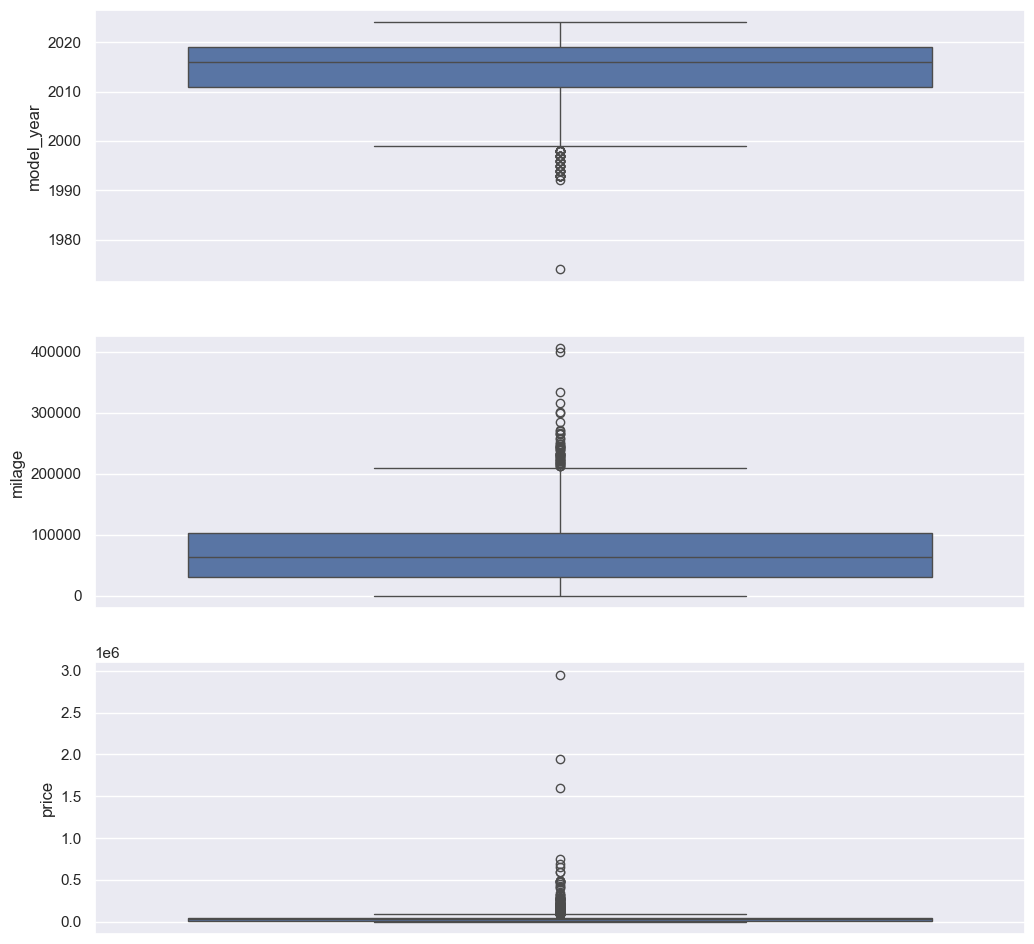

In [14]:
sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(3, figsize=(12, 12))

cols = ['model_year', 'milage', 'price']
for i in range(3):
    sns.boxplot(df[cols[i]], ax=ax[i])

### По графику boxplot'а можно увидеть, что у нас есть выбросы. Уберем их из данных

In [15]:
q11 = df['model_year'].quantile(0.25)
q13 = df['model_year'].quantile(0.75)
iqr1 = q13 - q11
lower1 = q11 - 1.5 * iqr1
upper1 = q13 + 1.5 * iqr1

q21 = df['milage'].quantile(0.25)
q23 = df['milage'].quantile(0.75)
iqr2 = q23 - q21
lower2 = q21 - 1.5 * iqr2
upper2 = q23 + 1.5 * iqr2
lower1, upper1, lower2, upper2

q31 = df['price'].quantile(0.25)
q33 = df['price'].quantile(0.75)
iqr3 = q33 - q31
lower3 = q31 - 1.5 * iqr3
upper3 = q33 + 1.5 * iqr3

In [16]:
df_clean = df[((df['model_year'] >= lower1) & (df['model_year'] <= upper1))  # Очищенная от выбросов таблица
& ((df['milage'] >= lower2) & (df['milage'] <= upper2))
&((df['price'] >= lower3) & (df['price'] <= upper3))]

In [17]:
df_clean.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,38005
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,15500
6,Audi,S3 2.0T Premium Plus,2017,84000,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,0,31000
8,Lexus,RC 350 F Sport,2021,23436,Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,0,41927


In [18]:
df_clean.describe()

,model_year,milage,accident,price
count,2991.000000,2991.000000,2991.000000,2991.000000
mean,2014.769977,72062.402875,0.298228,31295.767636
std,5.583652,47803.766131,0.457557,20119.269837
min,1999.000000,100.000000,0.000000,2000.000000
25%,2011.000000,34000.000000,0.000000,15500.000000
50%,2016.000000,65000.000000,0.000000,27499.000000
75%,2019.000000,102100.000000,1.000000,42900.000000
max,2024.000000,209500.000000,1.000000,93000.000000


### Средняя цена машины - 31300 долларов, дисперсия цены - 20100 долларов

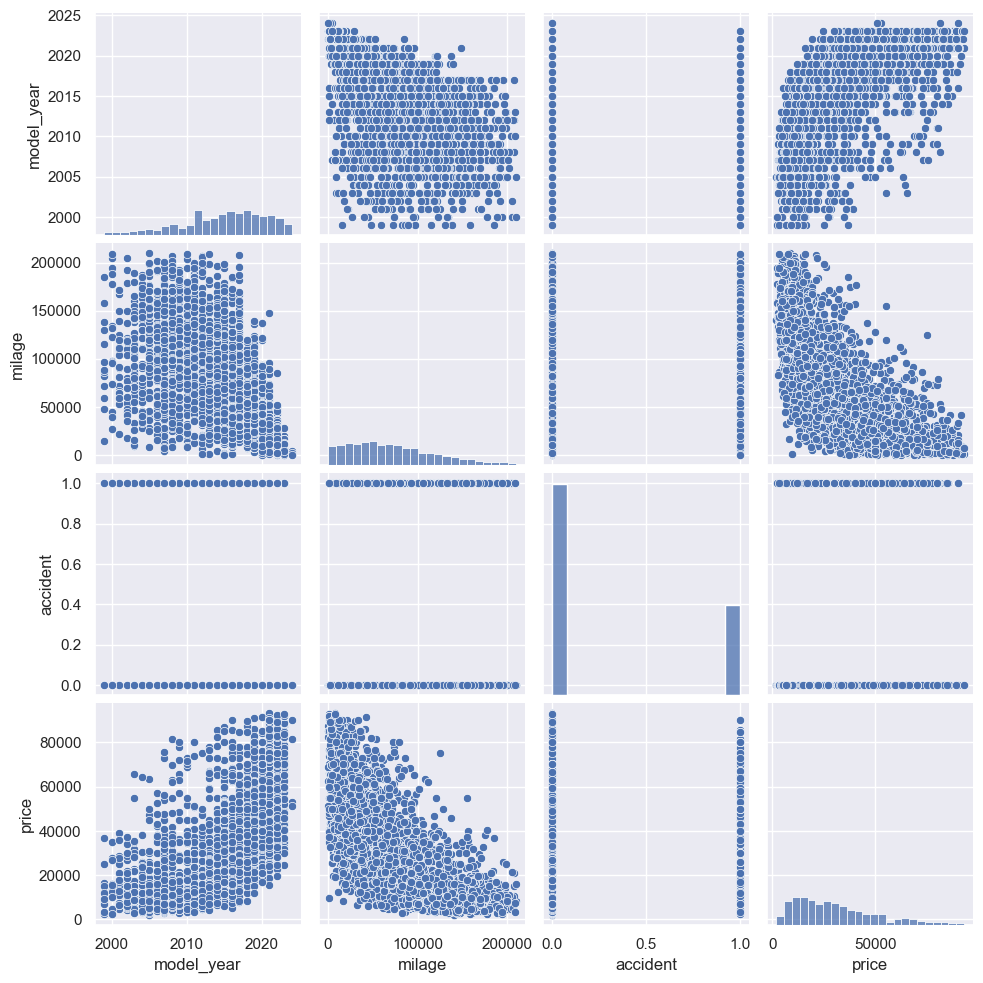

In [19]:
sns.pairplot(df_clean)

### Можем заметить из графика pairplot, что линейная регрессия неплохо подойдет, так как довольно четко видно направление для прямой линии

In [20]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics

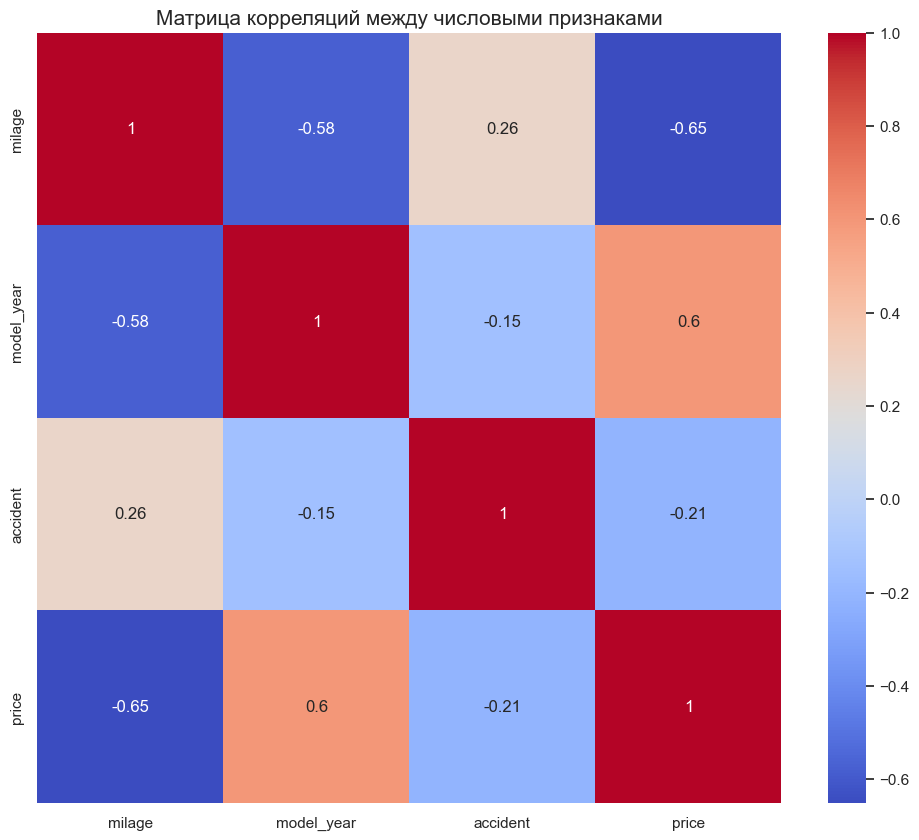

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=df_clean[['milage', 'model_year', 'accident', 'price']].corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций между числовыми признаками', fontsize=15)
plt.show()

### Можем увидеть, что есть явная корреляция между ценой и пробегом машины, годом выпуска, а также авариями, следовательно гипотеза 2 подтвердилась

In [22]:
df_new = df_clean.drop(['ext_col', 'int_col', 'engine', 'model'], axis=1)

In [23]:
df_new.head()

,brand,model_year,milage,fuel_type,transmission,accident,price
0,Ford,2013,51000,E85 Flex Fuel,6-Speed A/T,1,10300
1,Hyundai,2021,34742,Gasoline,8-Speed Automatic,1,38005
3,INFINITI,2015,88900,Hybrid,7-Speed A/T,0,15500
6,Audi,2017,84000,Gasoline,6-Speed A/T,0,31000
8,Lexus,2021,23436,Gasoline,6-Speed A/T,0,41927


### Уберем из fuel_type некорректные типы топлива

In [24]:
df_new['fuel_type'].unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Diesel', 'Plug-In Hybrid',
       '–', 'not supported'], dtype=object)

In [25]:
df_new2 = df_new[(df_new['fuel_type'] != '–') & (df_new['fuel_type'] != 'not supported')]
df_new2 = df_new2.set_index(np.arange(len(df_new2)))

In [26]:
df_new2.head()

,brand,model_year,milage,fuel_type,transmission,accident,price
0,Ford,2013,51000,E85 Flex Fuel,6-Speed A/T,1,10300
1,Hyundai,2021,34742,Gasoline,8-Speed Automatic,1,38005
2,INFINITI,2015,88900,Hybrid,7-Speed A/T,0,15500
3,Audi,2017,84000,Gasoline,6-Speed A/T,0,31000
4,Lexus,2021,23436,Gasoline,6-Speed A/T,0,41927


In [27]:
df_new2['fuel_type'].unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Diesel', 'Plug-In Hybrid'],
      dtype=object)

### Обработаем категориальные признаки марки машины и типа топлива

In [28]:
ohe = preprocessing.OneHotEncoder()
ohe.fit(df_new2[['fuel_type', 'brand']])

OneHotEncoder()

In [29]:
ohe.categories_

[array(['Diesel', 'E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Plug-In Hybrid'],
       dtype=object),
 array(['Acura', 'Alfa', 'Aston', 'Audi', 'BMW', 'Bentley', 'Buick',
        'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ford',
        'GMC', 'Genesis', 'Honda', 'Hummer', 'Hyundai', 'INFINITI',
        'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus', 'Lincoln', 'Lotus',
        'MINI', 'Maserati', 'Maybach', 'Mazda', 'Mercedes-Benz', 'Mercury',
        'Mitsubishi', 'Nissan', 'Plymouth', 'Pontiac', 'Porsche', 'RAM',
        'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki',
        'Toyota', 'Volkswagen', 'Volvo', 'smart'], dtype=object)]

In [30]:
arr = ohe.transform(df_new2[['fuel_type', 'brand']]).toarray()
arr.shape

(2972, 53)

In [31]:
names = ohe.get_feature_names_out()

In [32]:
data = pd.concat((df_new2[['model_year', 'milage', 'accident', 'price']],
                  pd.DataFrame(data=arr, columns=names)), axis=1)

In [33]:
data.head()

,model_year,milage,accident,price,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,brand_Acura,...,brand_Rolls-Royce,brand_Saab,brand_Saturn,brand_Scion,brand_Subaru,brand_Suzuki,brand_Toyota,brand_Volkswagen,brand_Volvo,brand_smart
0,2013,51000,1,10300,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,34742,1,38005,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,88900,0,15500,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,84000,0,31000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021,23436,0,41927,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Linear Regression

In [34]:
y = data['price']
X = data.drop('price', axis=1)

In [35]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.25,
                                                                    random_state=47,
                                                                    shuffle=True)

In [36]:
scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)


array([[ 1.29861879, -0.98727304, -0.66326652, ..., -0.1316954 ,
        -0.10210833,  0.        ],
       [-0.12932536, -0.41900163,  1.50768954, ..., -0.1316954 ,
        -0.10210833,  0.        ],
       [-2.27124158, -0.58323417, -0.66326652, ..., -0.1316954 ,
        -0.10210833,  0.        ],
       ...,
       [ 1.4771118 , -1.19067646, -0.66326652, ..., -0.1316954 ,
        -0.10210833,  0.        ],
       [ 1.29861879, -1.47271522, -0.66326652, ..., -0.1316954 ,
        -0.10210833,  0.        ],
       [ 0.94163275, -0.05230931, -0.66326652, ..., -0.1316954 ,
        -0.10210833,  0.        ]])

In [37]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

### Посмотрим на метрики:

In [38]:
mse_train = round(metrics.mean_squared_error(y_train, lin_reg.predict(X_train)) ** 0.5, 3)
mse_test = round(metrics.mean_squared_error(y_test, lin_reg.predict(X_test)) ** 0.5, 3)
mae_train = round(metrics.mean_absolute_error(y_train, lin_reg.predict(X_train)), 3)
mae_test = round(metrics.mean_absolute_error(y_test, lin_reg.predict(X_test)), 3)
r2_train = round(metrics.r2_score(y_true=y_train, y_pred=lin_reg.predict(X_train)), 3)
r2_test = round(metrics.r2_score(y_true=y_test, y_pred=lin_reg.predict(X_test)), 3)

metric_results = pd.DataFrame([{'MSE_train': mse_train, 'MSE_test': mse_test,
                                'MAE_train': mae_train, 'MAE_test': mae_test, 
                                'R2_train': r2_train, 'R2_test': r2_test}], index=['results'])
metric_results

,MSE_train,MSE_test,MAE_train,MAE_test,R2_train,R2_test
results,12173.815,12865.278,9256.526,9849.612,0.626,0.618


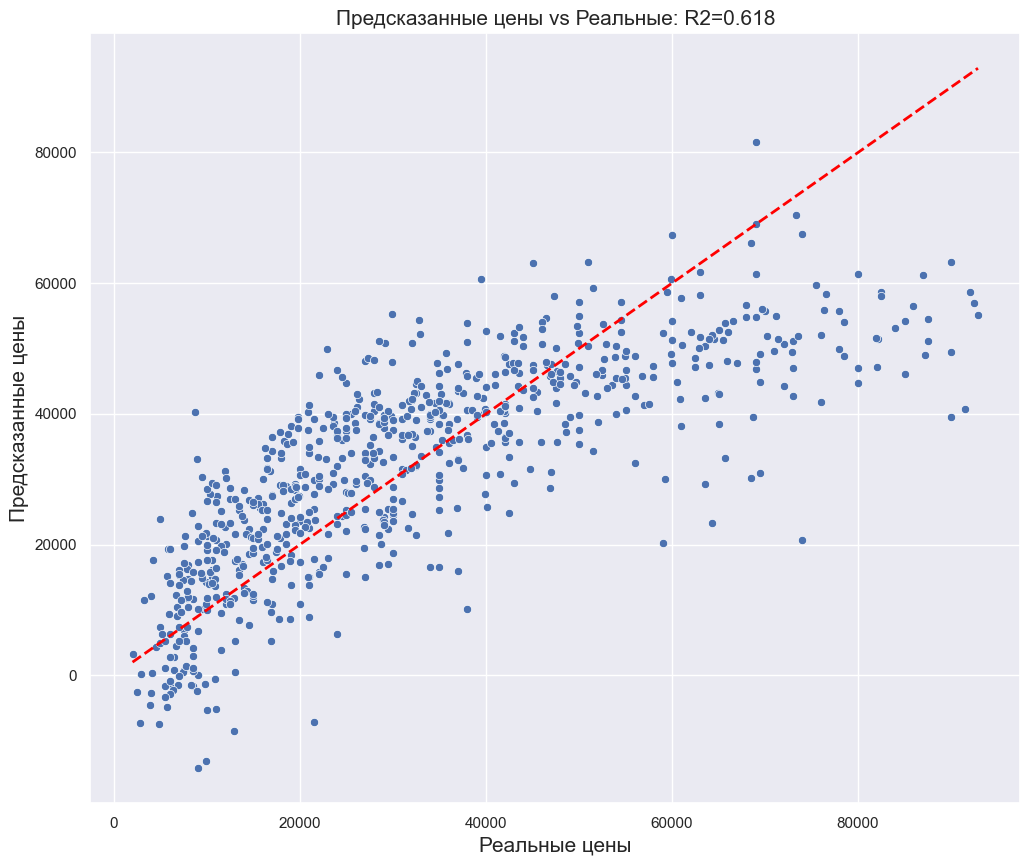

In [39]:
plt.figure(figsize=(12, 10))

sns.scatterplot(x=y_test, y=lin_reg.predict(X_test))
lims = [y_test.min(), y_test.max()]
sns.lineplot(x=lims, y=lims, linewidth=2, color='red', linestyle='--')

plt.title(f'Предсказанные цены vs Реальные: R2={r2_test}', fontsize=15)
plt.xlabel('Реальные цены', fontsize=15)
plt.ylabel('Предсказанные цены', fontsize=15)
plt.show()

In [40]:
lin_reg_l = linear_model.LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3])
lin_reg_r = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3])
lin_reg_net = linear_model.ElasticNetCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3])

lin_reg_l.fit(X_train, y_train)
lin_reg_r.fit(X_train, y_train)
lin_reg_net.fit(X_train, y_train)

ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0])

In [41]:
mse_train_l = round(metrics.mean_squared_error(y_train, lin_reg_l.predict(X_train)) ** 0.5, 3)
mse_train_r = round(metrics.mean_squared_error(y_train, lin_reg_r.predict(X_train)) ** 0.5, 3)
mse_train_net = round(metrics.mean_squared_error(y_train, lin_reg_net.predict(X_train)) ** 0.5, 3)

mse_test_l = round(metrics.mean_squared_error(y_test, lin_reg_l.predict(X_test)) ** 0.5, 3)
mse_test_r = round(metrics.mean_squared_error(y_test, lin_reg_r.predict(X_test)) ** 0.5, 3)
mse_test_net = round(metrics.mean_squared_error(y_test, lin_reg_net.predict(X_test)) ** 0.5, 3)

mae_train_l = round(metrics.mean_absolute_error(y_train, lin_reg_l.predict(X_train)), 3)
mae_train_r = round(metrics.mean_absolute_error(y_train, lin_reg_r.predict(X_train)), 3)
mae_train_net = round(metrics.mean_absolute_error(y_train, lin_reg_net.predict(X_train)), 3)

mae_test_l = round(metrics.mean_absolute_error(y_test, lin_reg_l.predict(X_test)), 3)
mae_test_r = round(metrics.mean_absolute_error(y_test, lin_reg_r.predict(X_test)), 3)
mae_test_net = round(metrics.mean_absolute_error(y_test, lin_reg_net.predict(X_test)), 3)

r2_train_l = round(metrics.r2_score(y_true=y_train, y_pred=lin_reg_l.predict(X_train)), 3)
r2_train_r = round(metrics.r2_score(y_true=y_train, y_pred=lin_reg_r.predict(X_train)), 3)
r2_train_net = round(metrics.r2_score(y_true=y_train, y_pred=lin_reg_net.predict(X_train)), 3)

r2_test_l = round(metrics.r2_score(y_true=y_test, y_pred=lin_reg_l.predict(X_test)), 3)
r2_test_r = round(metrics.r2_score(y_true=y_test, y_pred=lin_reg_r.predict(X_test)), 3)
r2_test_net = round(metrics.r2_score(y_true=y_test, y_pred=lin_reg_net.predict(X_test)), 3)


metric_results = pd.DataFrame({'MSE_train': [mse_train_l, mse_train_r, mse_train_net],
                                'MSE_test': [mse_test_l, mse_test_r, mse_test_net],
                                'MAE_train': [mae_train_l, mae_train_r, mae_train_net],
                                'MAE_test': [mae_test_l, mae_test_r, mae_test_net],
                                'R2_train': [r2_train_l, r2_train_r, r2_train_net],
                                'R2_test': [r2_test_l, r2_test_r, r2_test_net]},
                              index=['lasso', 'ridge', 'elasticNet'])
metric_results

,MSE_train,MSE_test,MAE_train,MAE_test,R2_train,R2_test
lasso,12174.400,12867.973,9260.050,9849.309,0.626,0.618
ridge,12231.314,12866.014,9450.949,9960.318,0.622,0.618
elasticNet,12202.514,12880.626,9288.639,9862.305,0.624,0.618


#### Так как коэффицент детерминации и средние ошибки почти не изменились, можно сделать вывод, что у нас оптимальные параметры. Гипотеза 4 не подтвердилась

### Decision Tree

In [42]:
y = data['price']
X = data.drop('price', axis=1)

In [43]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.25,
                                                                    random_state=47,
                                                                    shuffle=True)

In [44]:
clf = tree.DecisionTreeRegressor(max_depth=5)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5548906588415283

In [45]:
metrics.mean_squared_error(y_test, clf.predict(X_test)) ** 0.5


13895.443084876733

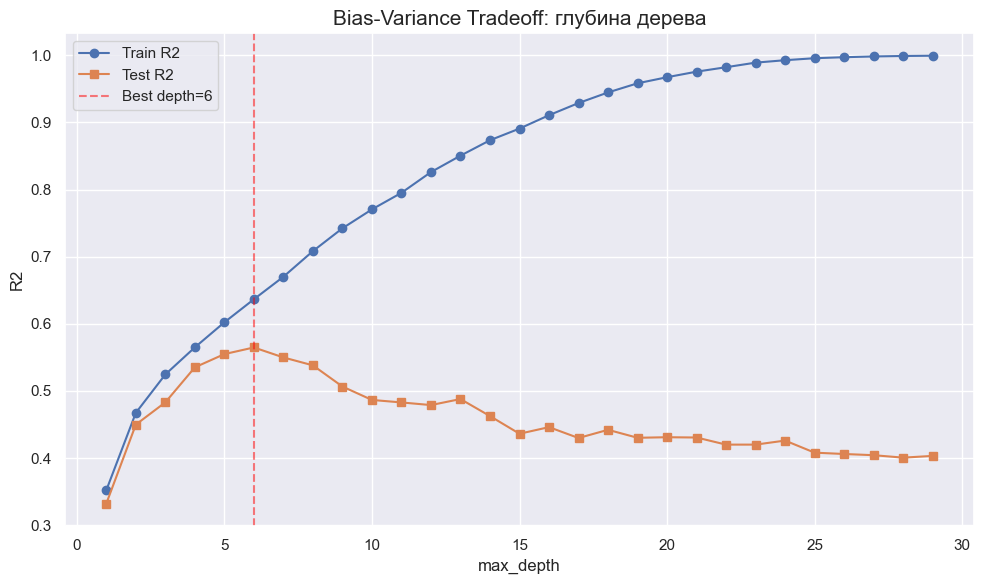

In [46]:
depths = range(1, 30)
train_acc, test_acc = [], []

for d in depths:
    dt = tree.DecisionTreeRegressor(max_depth=d, random_state=42).fit(X_train, y_train)
    train_acc.append(metrics.r2_score(y_train, dt.predict(X_train)))
    test_acc.append(metrics.r2_score(y_test, dt.predict(X_test)))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(depths, train_acc, 'o-', label='Train R2')
ax.plot(depths, test_acc, 's-', label='Test R2')
ax.axvline(x=depths[np.argmax(test_acc)], color='red', linestyle='--', alpha=0.5,
           label=f'Best depth={depths[np.argmax(test_acc)]}')
ax.set_xlabel('max_depth')
ax.set_ylabel('R2')
ax.set_title('Bias-Variance Tradeoff: глубина дерева', fontsize=15)
ax.legend()
plt.tight_layout()
plt.show()

### По графику видно, что начиная с глубины 6 и далее у нас падает R2_score, следовательно гипотеза 3 верна

### По итогу линейная регрессия выдала лучшие показатели в сравнение с деревом решений, скорее всего это произошло из-за того, что в начале я избавился от некоторых категориальных признаков, которые можно было попытаться как нибудь обработать